In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report


In [3]:
df = pd.read_csv("liver_cirrhosis.csv")
df.head()


,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [4]:
df.shape


(25000, 19)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [6]:
df = df.dropna(subset=["Stage"])
df.reset_index(drop=True, inplace=True)


In [7]:
categorical_cols = [
    "Status", "Drug", "Sex",
    "Ascites", "Hepatomegaly",
    "Spiders", "Edema"
]

numerical_cols = [col for col in df.columns if col not in categorical_cols + ["Stage"]]


In [8]:
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


In [9]:
X = df.drop("Stage", axis=1)
y = df["Stage"]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])


In [12]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [13]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9558


In [14]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.97      0.94      0.95      1657
           2       0.93      0.96      0.95      1697
           3       0.97      0.97      0.97      1646

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



In [15]:
model = pipeline.named_steps["model"]
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df.head(10)


,Feature,Importance
17,Prothrombin,0.140042
16,Platelets,0.112677
11,Albumin,0.106550
0,N_Days,0.105546
3,Age,0.083172
9,Bilirubin,0.070623
14,SGOT,0.052257
13,Alk_Phos,0.049547
6,Hepatomegaly,0.049196
12,Copper,0.048518


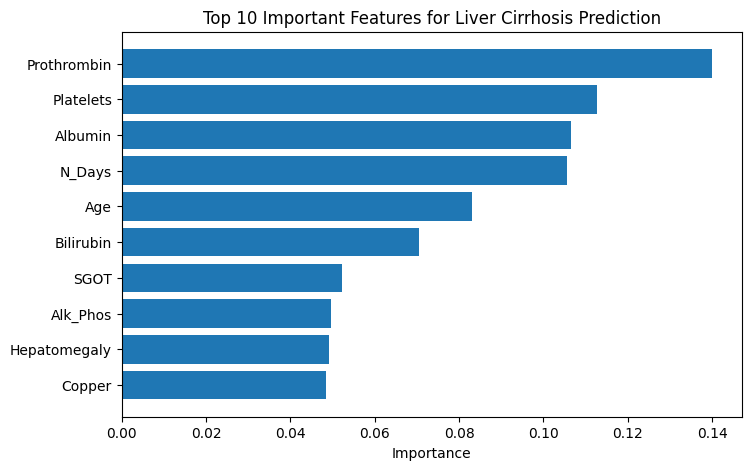

In [16]:
plt.figure(figsize=(8,5))
plt.barh(
    feature_importance_df["Feature"].head(10),
    feature_importance_df["Importance"].head(10)
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Important Features for Liver Cirrhosis Prediction")
plt.show()


In [17]:
sample_input = X.iloc[0].values.reshape(1, -1)
pipeline.predict(sample_input)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


array([1])

In [18]:
pipeline.predict_proba(sample_input)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


array([[1., 0., 0.]])

In [19]:
with open("model.pkl", "wb") as f:
    pickle.dump(pipeline, f)
